In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import dynamical_systems_routines as dsr
import my_causation_entropy_builder as my_ceb
import knn_mi_comp as mi 
import pickle 
%matplotlib inline

In [2]:
def windowed_deprecation(dep_fac, tseries):
    ndims, nstps = tseries.shape
    avg_window = np.ones((dep_fac,1))/dep_fac
    n_dep_stps = int(np.floor(nstps/dep_fac))
    
    tseries_dep = np.zeros((ndims, 2*n_dep_stps))
    for jj in range(n_dep_stps):
        tseries_dep[:, 2*jj] = np.squeeze(tseries[:, jj*dep_fac:(jj+1)*dep_fac] @ avg_window)            
        if jj < n_dep_stps-1:
            tseries_dep[:, 2*jj+1] = np.squeeze(
                tseries[:, int(dep_fac/2) + jj*dep_fac:int(dep_fac/2) + (jj+1)*dep_fac] @ avg_window)            
    
    #tavg = np.mean(tseries_dep, axis=1)
    #for kk in range(ndims):
    #    var = np.sqrt(np.mean( (tseries_dep[kk, :] - tavg[kk])**2. ))
    #    tseries_dep[kk, :] = (tseries_dep[kk, :]-tavg[kk])/var

    return tseries_dep

In [26]:
coupling_strength = 10.
dt = .01
coupled_data = dsr.generate_coupled(x1min=-2, x1max=2, x2min=-2, x2max=2, x3min=-2, x3max=2, num_ic=100, dt=dt, tf=150.0, coupling=coupling_strength, delay=0)

Generating Coupled Lorenz-Rossler system data...: 100%|███████████| 100/100 [00:18<00:00,  5.27it/s]


In [27]:
traj = 9
skp = int(np.round(120/dt))
lyupvals = np.zeros(6,dtype=np.float64)
for jj in range(100):
    lyupvals += dsr.lorenz_rossler_lyupanov_solver(yt=coupled_data[jj, :, skp:], Cval=coupling_strength, dt=dt)
print(lyupvals/100.)

[-3.06399031e+00 -3.74244041e+00 -6.85559548e+00  4.23798465e-01
  2.61885985e-02 -3.22845601e+01]


In [28]:
rscled_data = np.zeros((coupled_data.shape[0], coupled_data.shape[1], coupled_data.shape[2]))
for jj in range(coupled_data.shape[0]):
    avg = np.tile(np.mean(np.squeeze(coupled_data[jj, :, :]), axis=1).reshape(-1, 1), (1, coupled_data.shape[2]))
    rscled_data[jj, :, :]  = coupled_data[jj, :, :] - avg
    rscled_var = np.sqrt(np.tile(np.mean( rscled_data[jj, :, :]**2., axis=1 ).reshape(-1,1), (1,coupled_data.shape[2])))
    rscled_data[jj, :, :] /= rscled_var

In [29]:
def it_lag_graph(tseries, max_lag, kneighbor):
    ndims = tseries.shape[0]
    osteps_it = np.zeros((ndims, max_lag), dtype=np.float64)
    for jj in range(ndims):
        for ll in range(1, max_lag+1):
            forward = tseries[jj, ll:].reshape(-1,1)
            backward = tseries[jj, :-ll].reshape(-1,1) 
            osteps_it[jj, ll-1] = mi.miknn(forward, backward, kneighbor)
        
    return osteps_it

In [30]:
dep = 5
traj = 9
avg_data = coupled_data[traj, :, skp::dep]
rscl_data = rscled_data[traj, :, skp::dep]

max_lag = 49

kneighbor = 3
osteps_it_rscl = it_lag_graph(rscl_data, max_lag=max_lag, kneighbor=kneighbor)

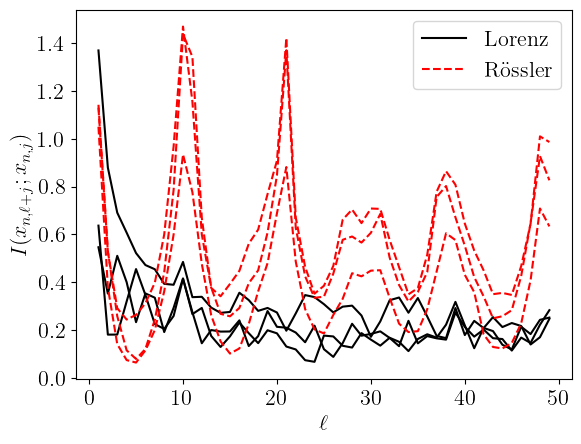

In [31]:
lags = np.arange(1, max_lag+1, dtype=int)
for jj in range(6):
    if jj < 3:
        if jj == 0:
            plt.plot(lags, osteps_it_rscl[jj, :], c='k', label=r"Lorenz")
        else:
            plt.plot(lags, osteps_it_rscl[jj, :], c='k')
    else:
        if jj == 3:
            plt.plot(lags, osteps_it_rscl[jj, :], c='r', ls='--', label=r"R\"{o}ssler")
        else:
            plt.plot(lags, osteps_it_rscl[jj, :], c='r', ls='--')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$I(x_{n,\ell+j};x_{n,j})$")
plt.legend()
plt.savefig("Lorenz_Rossler_lag_test_Cval_" + str(coupling_strength)
            +"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

In [15]:
def statistics_maker(all_results, ntrials):
    avg_source_info_mat = np.zeros((6,6),dtype=np.float64)
    avg_te_mat = np.zeros((6,6),dtype=np.float64)
    avg_it_mat = np.zeros((6,6),dtype=np.float64)
    var_source_info_mat = np.zeros((6,6),dtype=np.float64)
    var_te_mat = np.zeros((6,6),dtype=np.float64)
    var_it_mat = np.zeros((6,6),dtype=np.float64)

    for jj in range(ntrials):
        avg_source_info_mat += all_results[jj].source_info_mat
        avg_te_mat += all_results[jj].te_mat
        avg_it_mat += all_results[jj].it_mat

    avg_source_info_mat /= ntrials
    avg_te_mat /= ntrials
    avg_it_mat /= ntrials

    for jj in range(ntrials):
        var_source_info_mat += (all_results[jj].source_info_mat - avg_source_info_mat)**2.
        var_te_mat += (all_results[jj].te_mat - avg_te_mat)**2.
        var_it_mat += (all_results[jj].it_mat - avg_it_mat)**2.

    var_source_info_mat /= ntrials
    var_te_mat /= ntrials
    var_it_mat /= ntrials
    return avg_source_info_mat, avg_it_mat, avg_te_mat, var_source_info_mat, var_te_mat, var_it_mat

In [16]:
alpha_m = .05
max_lag = 1
kneighbor = 3
ntrials = 100

all_results = [None]*ntrials
for jj in range(ntrials):
    results_graph_rscl = my_ceb.Model_Graph(data=rscl_data, max_lag=max_lag, 
                                            kneighbor=kneighbor, alpha_m=alpha_m)
    results_graph_rscl.et_graph_model_builder()
    all_results[jj] = results_graph_rscl
    pickle.dump(all_results, open("lorenz_results_max_lag_"
                                  +str(max_lag)+"coupling_"+str(coupling_strength)+".pkl", "wb"))
    
    #results_graph_rscl.et_graph_model_builder()

For target 0
Target model: [1]
Chosen sources: [[1]]
Final information content of model: 1.4879825647311615

For target 1
Target model: [1]
Chosen sources: [[1], [0, 2, 4]]
Final information content of model: 0.5288219390684299

For target 2
Target model: [1]
Chosen sources: [[1], [0, 2, 4], [1, 0]]
Final information content of model: 1.1985970979812692

For target 3
Target model: [1]
Chosen sources: [[1], [0, 2, 4], [1, 0], [4, 5]]
Final information content of model: 1.3013956359822758

For target 4
Target model: [1]
Chosen sources: [[1], [0, 2, 4], [1, 0], [4, 5], [3]]
Final information content of model: 1.317065763024805

For target 5
Target model: [1]
Chosen sources: [[1], [0, 2, 4], [1, 0], [4, 5], [3], [3]]
Final information content of model: 0.6644270813101282

For target 0
Target model: [1]
Chosen sources: [[1]]
Final information content of model: 1.4879825647311615

For target 1
Target model: [1]
Chosen sources: [[1], [0, 2, 4]]
Final information content of model: 0.5288219390

In [17]:
avg_source_info_mat, avg_it_mat, avg_te_mat, var_source_info_mat, var_te_mat, var_it_mat = statistics_maker(all_results, ntrials=ntrials)

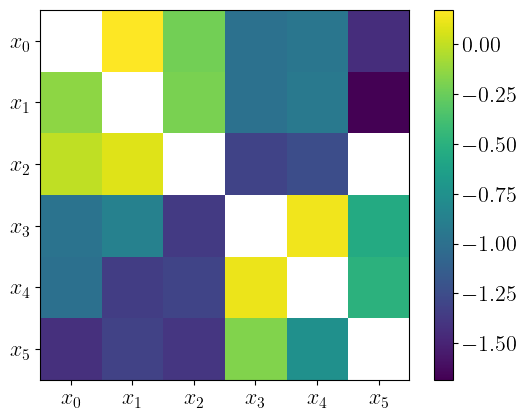

In [18]:
results_graph_rscl.mat_visualizer(avg_source_info_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_source_info_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

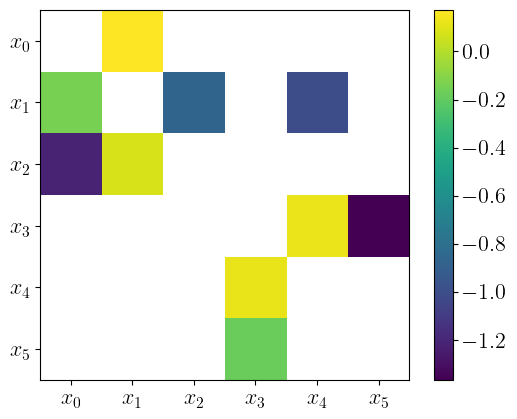

In [19]:
results_graph_rscl.mat_visualizer(avg_te_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_tevals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

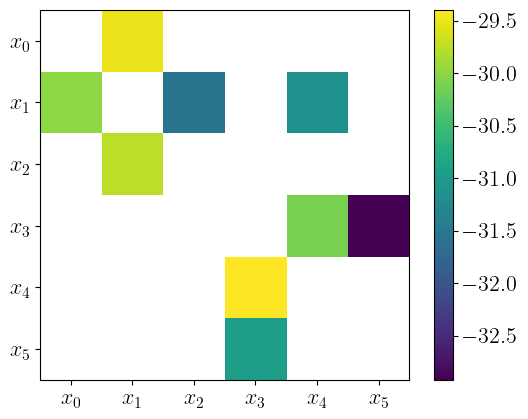

In [20]:
results_graph_rscl.mat_visualizer(var_te_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_var_tevals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

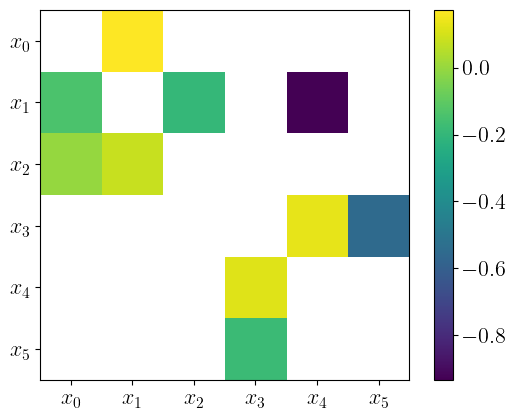

In [21]:
results_graph_rscl.mat_visualizer(avg_it_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_itvals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

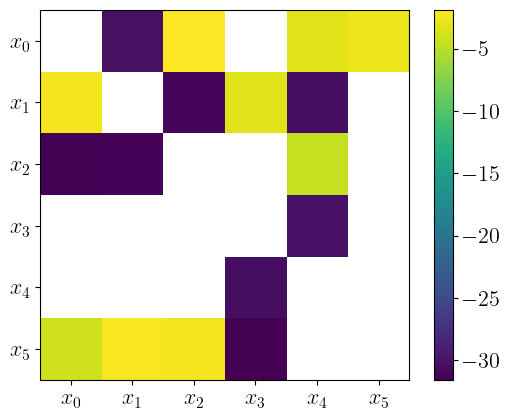

In [104]:
results_graph_rscl.mat_visualizer(var_it_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_var_itvals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

[[2, 4, 1], [2, 4], [1], [4, 5], [3, 5], [4, 3]]


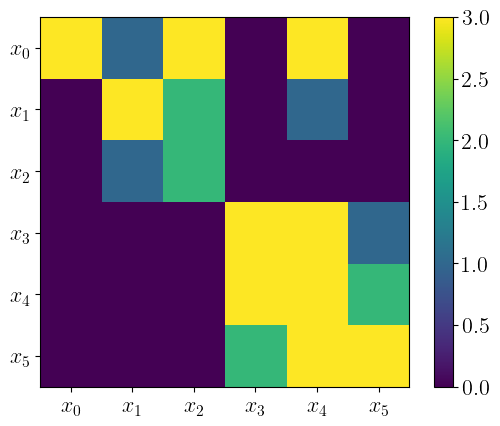

In [22]:
lag_matrix = np.zeros((6, 6), dtype=int)
for cnt, target in enumerate(results_graph_rscl.target_models):
    lag_matrix[cnt, cnt] = max(target.model)

all_original_indices = results_graph_rscl.chosen_sources_original_indices
print(all_original_indices)
for cnt, best_e_graph in enumerate(results_graph_rscl.source_models):
    my_original_indices = all_original_indices[cnt]
    for next_cnt, source_label in enumerate(best_e_graph.chosen_sources):
        lag_matrix[cnt, my_original_indices[next_cnt]] = max(best_e_graph.sources[source_label].model)

results_graph_rscl.mat_visualizer(lag_matrix, 'x', False, 'viridis')
plt.savefig("Lorenz_Rossler_lags_Cval_" + str(coupling_strength) + "_max_lag_" + str(max_lag) + ".pdf", dpi=150, bbox_inches='tight')  

In [51]:
max_lag = 3
all_traj_results = [None]*rscled_data.shape[0]
for jj in range(rscled_data.shape[0]):
    results_graph_rscl = my_ceb.Model_Graph(data=rscled_data[jj, :, skp::dep], max_lag=max_lag, 
                                            kneighbor=kneighbor, alpha_m=alpha_m)
    results_graph_rscl.et_graph_model_builder()
    all_traj_results[jj] = results_graph_rscl
    pickle.dump(all_traj_results, open("lorenz_traj_results_max_lag_"
                                  +str(max_lag)+"coupling_"+str(coupling_strength)+".pkl", "wb"))
    

For target 0
Target model: [1, 3]
Chosen sources: [[2, 4, 1]]
Final information content of model: 0.2800048589250971

For target 1
Target model: [1, 3]
Chosen sources: [[2, 4, 1], [2, 4]]
Final information content of model: 0.21770894788190598

For target 2
Target model: [1, 2]
Chosen sources: [[2, 4, 1], [2, 4], [1]]
Final information content of model: 0.4212450678990266

For target 3
Target model: [1, 3]
Chosen sources: [[2, 4, 1], [2, 4], [1], [4, 5]]
Final information content of model: 0.29469657219075085

For target 4
Target model: [1, 3]
Chosen sources: [[2, 4, 1], [2, 4], [1], [4, 5], [3]]
Final information content of model: 0.2517133827101663

For target 5
Target model: [1, 2, 3]
Chosen sources: [[2, 4, 1], [2, 4], [1], [4, 5], [3], [4, 3]]
Final information content of model: 0.21663450763182734

For target 0
Target model: [1, 3]
Chosen sources: [[1]]
Final information content of model: 0.44686477080465753

For target 1
Target model: [1, 3]
Chosen sources: [[1], [2, 3]]
Final i

In [52]:
avg_source_info_mat, avg_it_mat, avg_te_mat, var_source_info_mat, var_te_mat, var_it_mat = statistics_maker(all_traj_results, ntrials=rscled_data.shape[0])

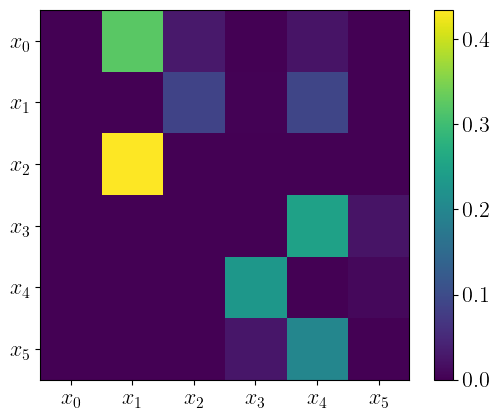

In [76]:
results_graph_rscl.mat_visualizer(10**avg_te_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_traj_tevals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

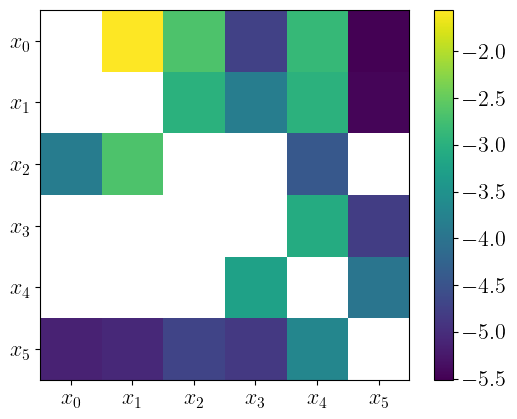

In [58]:
results_graph_rscl.mat_visualizer(var_te_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_traj_var_tevals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

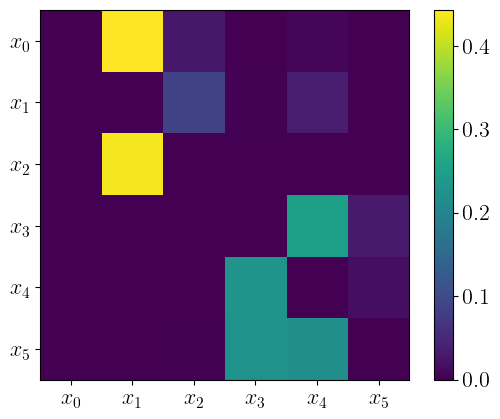

In [77]:
results_graph_rscl.mat_visualizer(10**avg_it_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_traj_itvals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  

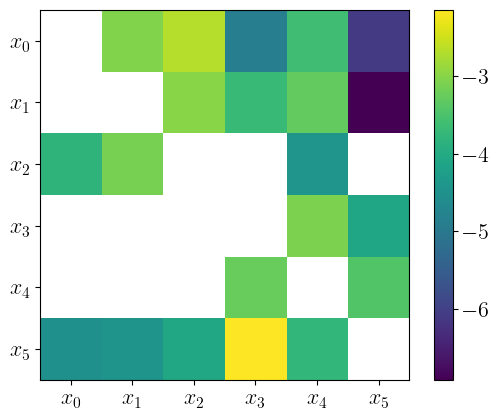

In [56]:
results_graph_rscl.mat_visualizer(var_it_mat, 'x', True, 'viridis')
plt.savefig("Lorenz_Rossler_traj_var_itvals_Cval_" + str(coupling_strength)
            + "_pval_"+str(alpha_m)+"_max_lag_"+str(max_lag) 
            + "_dep_" + str(dep) + ".pdf", dpi=150, bbox_inches='tight')  